# Check on the contrast phantoms

In [1]:
import platform
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches
import seaborn
import pandas
import numpy
from tqdm import notebook
from itkwidgets import view  # 3d viewer
import imageio
import dask
import dask.array as da
import dask_image.imread
from distributed import Client
client = Client(processes=False,
#                 local_directory='F:\tmp',
#                 n_workers=32,
#                 silence_logs=True
               )
# Then go to http://localhost:8787/status
from numcodecs import Blosc


Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.


In [2]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:62086/status"


In [3]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [4]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [5]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [6]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [7]:
# Different locations if running either on Linux or Windows
FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'Chondrules Space Yogita', 'ContrastPhantoms')
print('We are loading all the data from %s' % Root)

We are loading all the data from D:\Results\Chondrules Space Yogita\ContrastPhantoms


In [8]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [9]:
def get_filter(logfile):
    """Get the filter we used whole scanning from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Filter=' in line:
                whichfilter = line.split('=')[1].strip()
    return(whichfilter)

In [10]:
def get_exposuretime(logfile):
    """Get the exposure time size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Exposure' in line:
                exposuretime = int(line.split('=')[1])
    return(exposuretime)

In [11]:
def get_ringartefact(logfile):
    """Get the ring artefact correction from the  scan log file"""
    ringartefactcorrection = numpy.nan
    with open(logfile, 'r') as f:
        for line in f:
            if 'Ring Artifact' in line:
                ringartefactcorrection = int(line.split('=')[1])
    return(ringartefactcorrection)

In [12]:
def get_reconstruction_grayvalue(logfile):
    """How did we map the brightness of the reconstructions?"""
    grayvalue = numpy.nan
    with open(logfile, 'r') as f:
        for line in f:
            if 'Maximum for' in line:
                grayvalue = float(line.split('=')[1])
    return(grayvalue)

In [13]:
def get_beamhardening(logfile):
    """Get the beamhardening correction from the  scan log file"""
    beamhardeningcorrection = numpy.nan
    with open(logfile, 'r') as f:
        for line in f:
            if 'Hardening' in line:
                beamhardeningcorrection = int(line.split('=')[1])
    return(beamhardeningcorrection)

In [14]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [15]:
# Get *all* projection log files
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'), recursive=True))]

In [16]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [17]:
# Get the necessary information
Data['Sample'] = [(f[len(Root)+1:]).split(os.sep)[0] for f in Data['Folder']]
Data['Scan'] = [(f[len(Root)+1:]).split(os.sep)[1] for f in Data['Folder']]
Data['SampleNameLength'] = [len(sn) for sn in Data['Sample']]
Data['ScanNameLength'] = [len(sn) for sn in Data['Scan']]

In [18]:
print('We found %s log files to work with' % len(Data))

We found 31 log files to work with


In [19]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]
Data['Filter'] = [get_filter(log) for log in Data['LogFile']]
Data['Exposuretime'] = [get_exposuretime(log) for log in Data['LogFile']]
Data['Grayvalue'] = [get_reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [get_ringartefact(log) for log in Data['LogFile']]
Data['BeamHardeninCorrection'] = [get_beamhardening(log) for log in Data['LogFile']]

In [20]:
# Check for reconstructions
for c, row in Data.iterrows():
    if not len(glob.glob(os.path.join(os.path.dirname(row.Folder), '*rec*', '*.*'))):
        print('%s contains *no* reconstruction folder (or only an empty one)' % os.path.join(row.Sample, 'rec'))

In [21]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(os.path.dirname(lf),
                                                         '*.png'))) for lf in Data['LogFile']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [22]:
# Drop 'proj' folders and samples which have not been reconstructed yet
# Based on https://stackoverflow.com/a/13851602
for c, sample in Data[Data['Number of reconstructions'] == 0].iterrows():
    if not 'proj' in sample.LogFile:
        print('%s is empty' % os.path.dirname(sample.LogFile))
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions' % (len(Data)))

We have 13 folders with reconstructions


In [23]:
# Did we reconstruct them equally?
Data[['Sample',
      'Scan',
      'Voxelsize',
      'Filter',
      'Exposuretime',
      'Grayvalue',
      'RingartefactCorrection',
      'BeamHardeninCorrection']].to_excel('ScanParameters.xlsx')

In [24]:
# Did we reconstruct them equally?
Data[['Sample', 'Scan',  'Voxelsize', 'Filter', 'Exposuretime', 'Grayvalue', 'RingartefactCorrection', 'BeamHardeninCorrection']]

Sample Scan  Voxelsize    Filter  Exposuretime  Grayvalue  \
0      01_Albite  rec   3.699977  Al 0.5mm          2145        0.3   
1       01_BHVO2  rec   3.699977  Al 0.5mm          2145        0.3   
2         01_CPX  rec   3.699977  Al 0.5mm          2145        0.3   
3     01_FeMetal  rec   3.699977  Al 0.5mm          2145        0.3   
4   01_SCOlivine  rec   3.699977  Al 0.5mm          2145        0.3   
5      02_Albite  rec   3.699977  Al 0.5mm          1500        0.3   
6         02_BCR  rec   3.699977  Al 0.5mm          1500        0.3   
7       02_BHVO2  rec   3.699977  Al 0.5mm          1500        0.3   
8         02_CPX  rec   3.699977  Al 0.5mm          1500        0.3   
9       02_Glass  rec   3.699977  Al 0.5mm          1500        0.3   
10      02_Metal  rec   3.699977  Al 0.5mm          1500        0.3   
11        02_OPX  rec   3.699977  Al 0.5mm          1500        0.3   
12  02_SCOlivine  rec   3.699977  Al 0.5mm          1500        0.3   

    RingartefactCorrection  BeamHardeninCorrection  
0                        7                      50  
1                        7                      50  
2                        7                      50  
3                        7                      50  
4                        7                      50  
5                        7                      50  
6                        7                      50  
7                        7                      50  
8                        7                      50  
9                        7                      50  
10                       7                      50  
11                       7                      50  
12                       7                      50

In [25]:
print(Data['Voxelsize'].unique())
print(Data['Filter'].unique())
print(Data['RingartefactCorrection'].unique())
print(Data['BeamHardeninCorrection'].unique())

[3.699977]
['Al 0.5mm']
[7]
[50]


In [26]:
# Display some info
for c, row in Data.iterrows():
    print('%02s/%s: %s has %03s reconstructions' % (c + 1,
                                                    len(Data),
                                                    row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                    row['Number of reconstructions']), end=' ')
    if row['Scan']:
        print('in %s' %row['Scan'], end='\n')
    else:
        print(end='\n')

 1/13:    01_Albite has 230 reconstructions in rec
 2/13:     01_BHVO2 has 261 reconstructions in rec
 3/13:       01_CPX has 351 reconstructions in rec
 4/13:   01_FeMetal has 224 reconstructions in rec
 5/13: 01_SCOlivine has 209 reconstructions in rec
 6/13:    02_Albite has 206 reconstructions in rec
 7/13:       02_BCR has 271 reconstructions in rec
 8/13:     02_BHVO2 has 167 reconstructions in rec
 9/13:       02_CPX has 326 reconstructions in rec
10/13:     02_Glass has 221 reconstructions in rec
11/13:     02_Metal has 201 reconstructions in rec
12/13:       02_OPX has 302 reconstructions in rec
13/13: 02_SCOlivine has 242 reconstructions in rec


In [27]:
# Convert all reconstructions into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [os.path.join(os.path.dirname(f),
                                      sample + '_' + scan + '.zarr') for f, sample, scan in zip(Data.Folder,
                                                                                                Data.Sample,
                                                                                                Data.Scan)]
Reconstructions = [numpy.nan for file in Data['OutputNameRec']]
for c, row in notebook.tqdm(Data.iterrows(), desc='Generate .zarr', total=len(Data)):
    if not os.path.exists(row['OutputNameRec']):
        print('%2s/%s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                       len(Data),
                                                                       row['Number of reconstructions'],
                                                                       row['OutputNameRec'][len(Root):]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'], '*.png'))
        Reconstructions.to_zarr(row['OutputNameRec'],
                                overwrite=True,
                                compressor=Blosc(cname='zstd',
                                                 clevel=3,
                                                 shuffle=Blosc.BITSHUFFLE))

 1/13: Reading 230 reconstructions and saving to \01_Albite\01_Albite_rec.zarr
 2/13: Reading 261 reconstructions and saving to \01_BHVO2\01_BHVO2_rec.zarr
 3/13: Reading 351 reconstructions and saving to \01_CPX\01_CPX_rec.zarr
 4/13: Reading 224 reconstructions and saving to \01_FeMetal\01_FeMetal_rec.zarr
 5/13: Reading 209 reconstructions and saving to \01_SCOlivine\01_SCOlivine_rec.zarr
 6/13: Reading 206 reconstructions and saving to \02_Albite\02_Albite_rec.zarr
 7/13: Reading 271 reconstructions and saving to \02_BCR\02_BCR_rec.zarr
 8/13: Reading 167 reconstructions and saving to \02_BHVO2\02_BHVO2_rec.zarr
 9/13: Reading 326 reconstructions and saving to \02_CPX\02_CPX_rec.zarr
10/13: Reading 221 reconstructions and saving to \02_Glass\02_Glass_rec.zarr
11/13: Reading 201 reconstructions and saving to \02_Metal\02_Metal_rec.zarr
12/13: Reading 302 reconstructions and saving to \02_OPX\02_OPX_rec.zarr
13/13: Reading 242 reconstructions and saving to \02_SCOlivine\02_SCOlivine_

In [28]:
# Load the reconstructions a zarr arrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

In [29]:
# The three cardinal directions
directions = ['Axial', 'Sagittal', 'Coronal']

In [30]:
# How big are the datasets?
Data['Size'] = [numpy.shape(rec) for rec in Reconstructions]

In [31]:
Data[['Sample','Size']]

Sample             Size
0      01_Albite  (230, 312, 312)
1       01_BHVO2  (261, 304, 304)
2         01_CPX  (351, 304, 304)
3     01_FeMetal  (224, 304, 304)
4   01_SCOlivine  (209, 304, 304)
5      02_Albite  (206, 316, 316)
6         02_BCR  (271, 528, 528)
7       02_BHVO2  (167, 388, 388)
8         02_CPX  (326, 480, 480)
9       02_Glass  (221, 372, 372)
10      02_Metal  (201, 480, 480)
11        02_OPX  (302, 436, 436)
12  02_SCOlivine  (242, 412, 412)

In [32]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']), '%s.%s.MIP.%s.png' % (row['Sample'],
                                                                                         row['Scan'],
                                                                                         direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'MIP_' + direction].astype('uint8'))

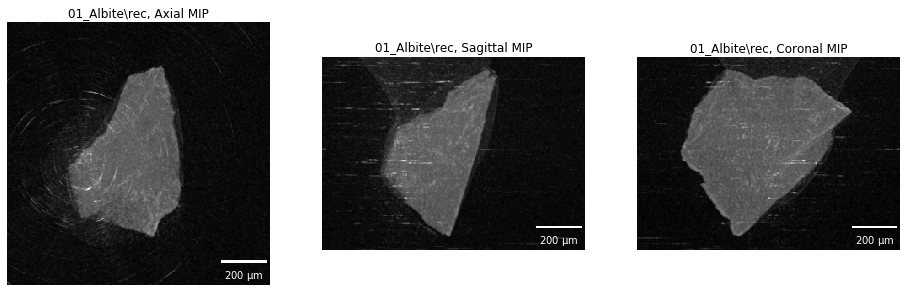

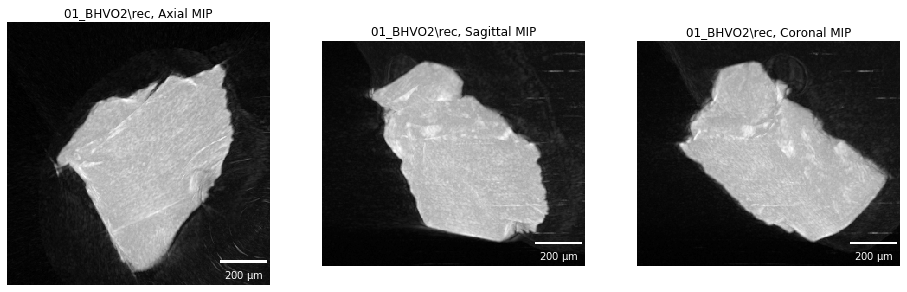

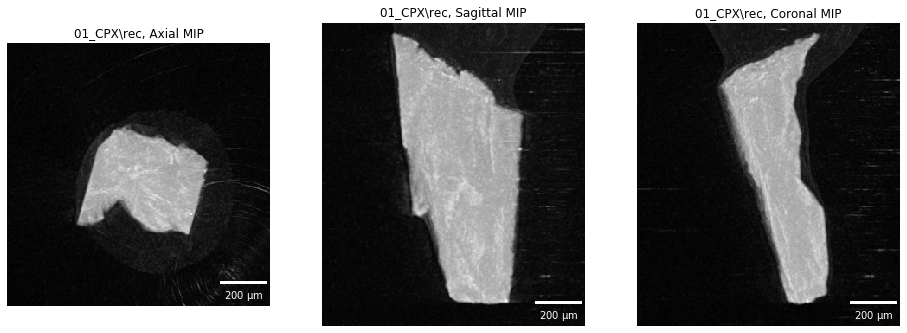

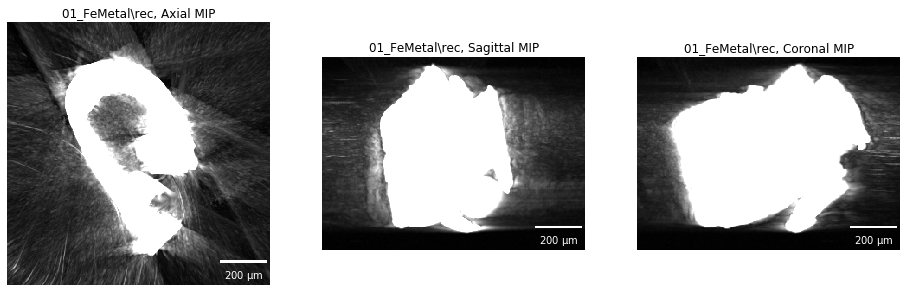

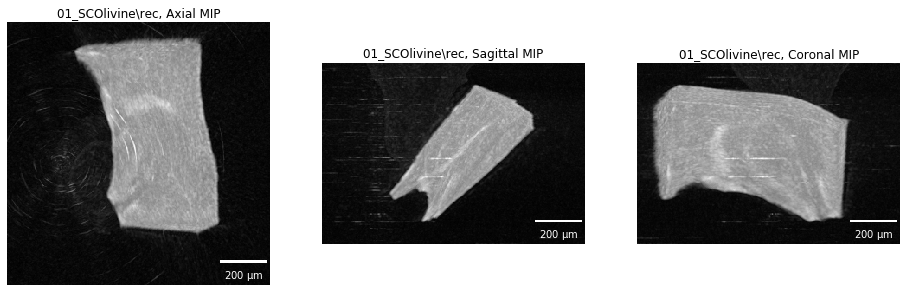

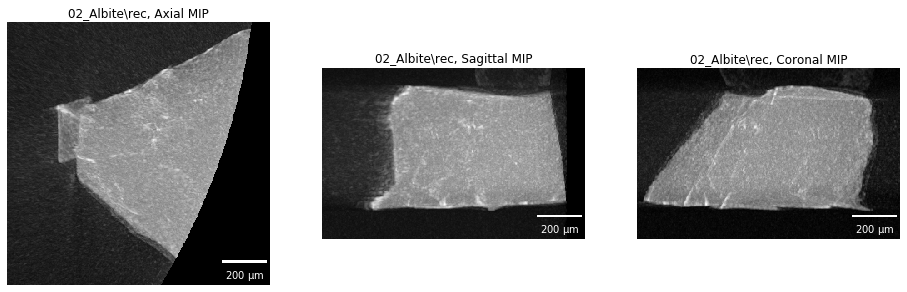

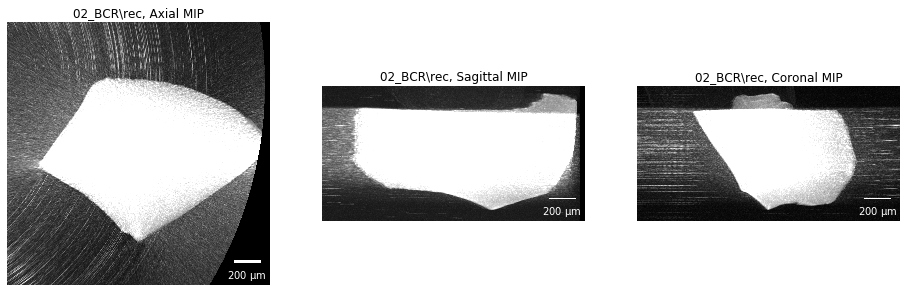

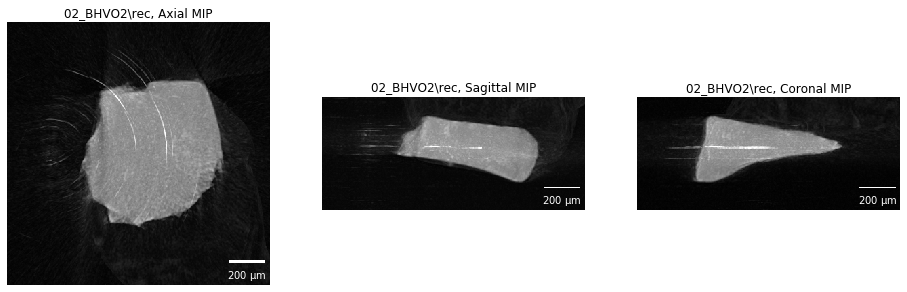

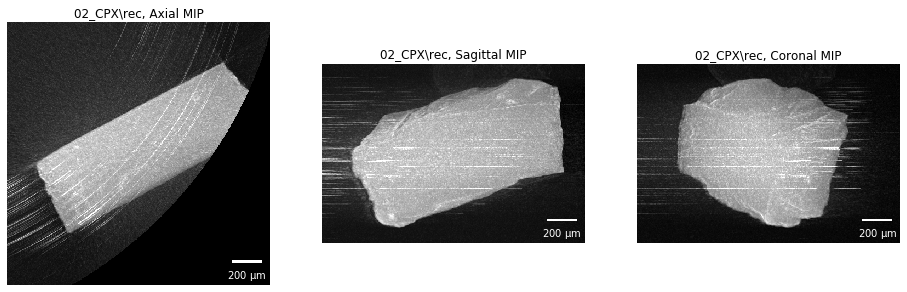

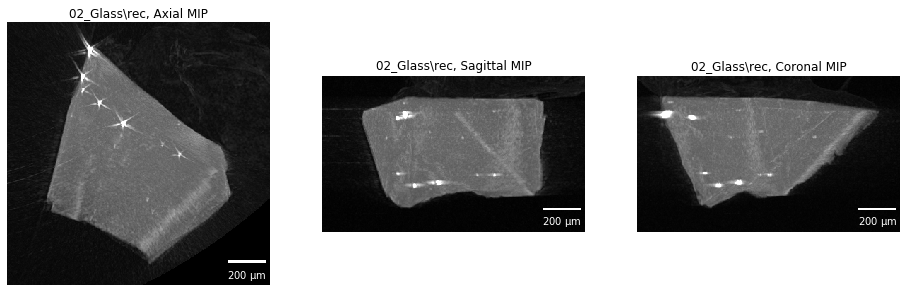

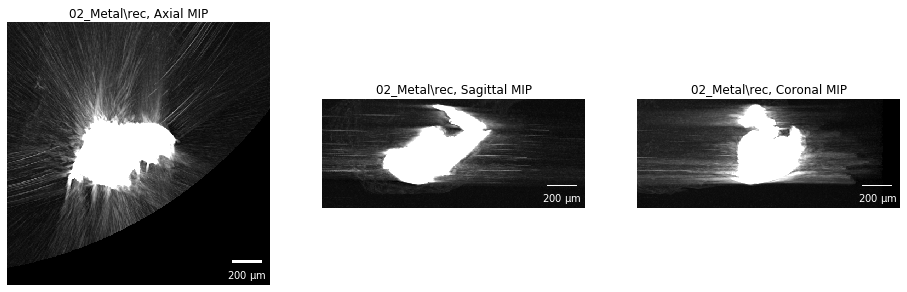

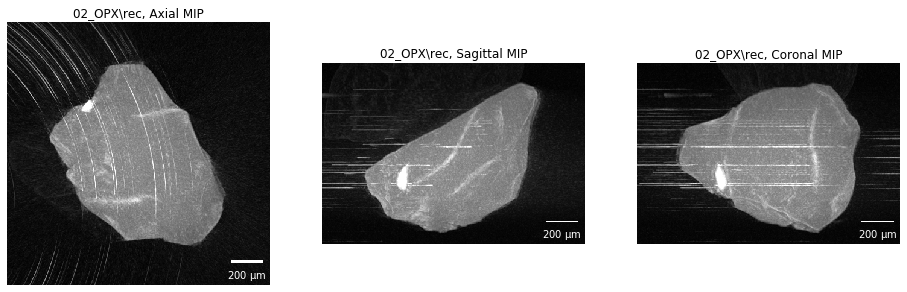

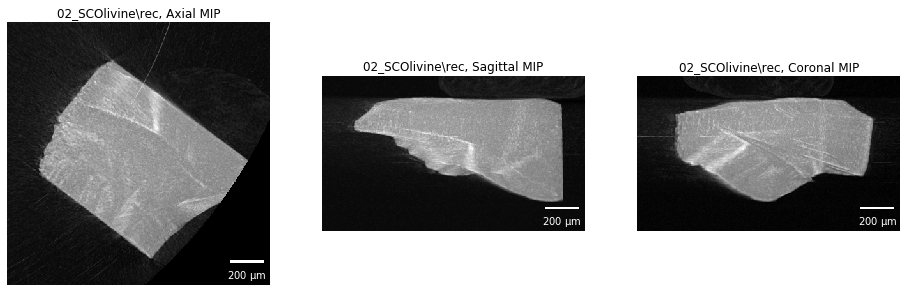

In [33]:
# Show MIP slices
for c, row in Data.iterrows():
    outputfile = os.path.join(os.path.dirname(row['Folder']), '%s.%s.MIPs.png' % (row['Sample'], row['Scan']))
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        if row['Scan']:
            plt.title('%s, %s' % (os.path.join(row['Sample'], row['Scan']),
                                  direction + ' MIP'))
        else:
            plt.title('%s, %s' % (row['Sample'],
                                  direction + ' MIP'))
        plt.axis('off')
    if not os.path.exists(outputfile):
        plt.savefig(outputfile,
                    transparent=False,
                    bbox_inches='tight')
    plt.show()

In [34]:
Data.head()

LogFile  \
0  D:\Results\Chondrules Space Yogita\ContrastPha...   
1  D:\Results\Chondrules Space Yogita\ContrastPha...   
2  D:\Results\Chondrules Space Yogita\ContrastPha...   
3  D:\Results\Chondrules Space Yogita\ContrastPha...   
4  D:\Results\Chondrules Space Yogita\ContrastPha...   

                                              Folder        Sample Scan  \
0  D:\Results\Chondrules Space Yogita\ContrastPha...     01_Albite  rec   
1  D:\Results\Chondrules Space Yogita\ContrastPha...      01_BHVO2  rec   
2  D:\Results\Chondrules Space Yogita\ContrastPha...        01_CPX  rec   
3  D:\Results\Chondrules Space Yogita\ContrastPha...    01_FeMetal  rec   
4  D:\Results\Chondrules Space Yogita\ContrastPha...  01_SCOlivine  rec   

   SampleNameLength  ScanNameLength  Voxelsize    Filter  Exposuretime  \
0                 9               3   3.699977  Al 0.5mm          2145   
1                 8               3   3.699977  Al 0.5mm          2145   
2                 6               3   3.699977  Al 0.5mm          2145   
3                10               3   3.699977  Al 0.5mm          2145   
4                12               3   3.699977  Al 0.5mm          2145   

   Grayvalue  RingartefactCorrection  BeamHardeninCorrection  \
0        0.3                       7                      50   
1        0.3                       7                      50   
2        0.3                       7                      50   
3        0.3                       7                      50   
4        0.3                       7                      50   

                                     Reconstructions  \
0  [D:\Results\Chondrules Space Yogita\ContrastPh...   
1  [D:\Results\Chondrules Space Yogita\ContrastPh...   
2  [D:\Results\Chondrules Space Yogita\ContrastPh...   
3  [D:\Results\Chondrules Space Yogita\ContrastPh...   
4  [D:\Results\Chondrules Space Yogita\ContrastPh...   

   Number of reconstructions  \
0                        230   
1                        261   
2                        351   
3                        224   
4                        209   

                                       OutputNameRec             Size  \
0  D:\Results\Chondrules Space Yogita\ContrastPha...  (230, 312, 312)   
1  D:\Results\Chondrules Space Yogita\ContrastPha...  (261, 304, 304)   
2  D:\Results\Chondrules Space Yogita\ContrastPha...  (351, 304, 304)   
3  D:\Results\Chondrules Space Yogita\ContrastPha...  (224, 304, 304)   
4  D:\Results\Chondrules Space Yogita\ContrastPha...  (209, 304, 304)   

                                           MIP_Axial  \
0  [[24, 18, 16, 14, 13, 13, 15, 15, 14, 13, 12, ...   
1  [[6, 6, 7, 7, 9, 8, 6, 6, 5, 7, 6, 6, 10, 8, 8...   
2  [[10, 10, 10, 11, 10, 9, 9, 11, 10, 11, 11, 10...   
3  [[5, 5, 5, 4, 7, 7, 18, 18, 19, 22, 25, 31, 38...   
4  [[11, 11, 12, 13, 14, 13, 15, 15, 14, 14, 11, ...   

                                        MIP_Sagittal  \
0  [[19, 18, 15, 16, 15, 18, 14, 15, 15, 15, 15, ...   
1  [[6, 6, 7, 7, 7, 4, 7, 7, 6, 6, 6, 5, 6, 6, 5,...   
2  [[9, 10, 9, 11, 10, 11, 11, 10, 9, 11, 12, 13,...   
3  [[26, 28, 30, 30, 29, 29, 27, 25, 28, 29, 30, ...   
4  [[18, 18, 14, 14, 12, 13, 18, 13, 16, 16, 14, ...   

                                         MIP_Coronal  
0  [[20, 13, 13, 15, 15, 14, 13, 15, 14, 14, 16, ...  
1  [[7, 5, 7, 6, 6, 8, 7, 7, 7, 5, 5, 6, 7, 8, 8,...  
2  [[9, 15, 13, 9, 12, 12, 9, 9, 11, 10, 10, 13, ...  
3  [[7, 7, 5, 5, 7, 7, 6, 6, 6, 6, 6, 6, 6, 8, 9,...  
4  [[13, 10, 12, 11, 13, 10, 11, 13, 11, 11, 12, ...

Axial


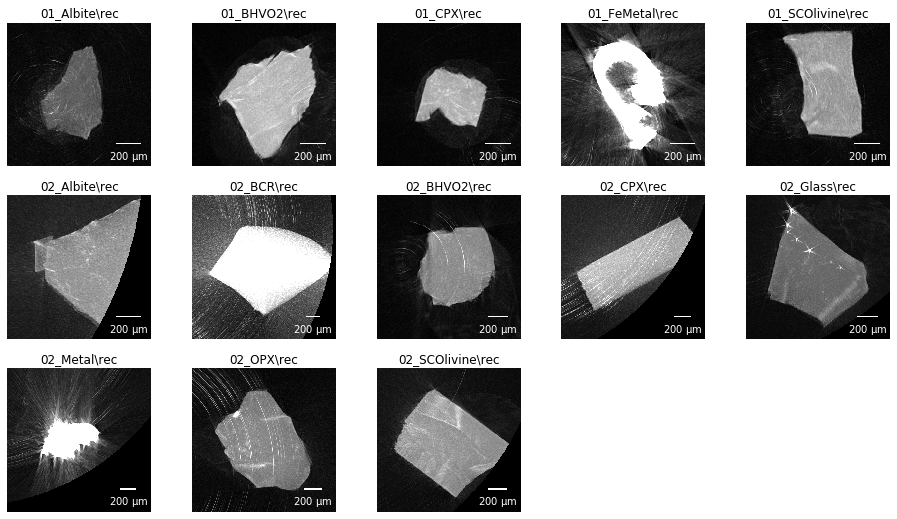

Sagittal


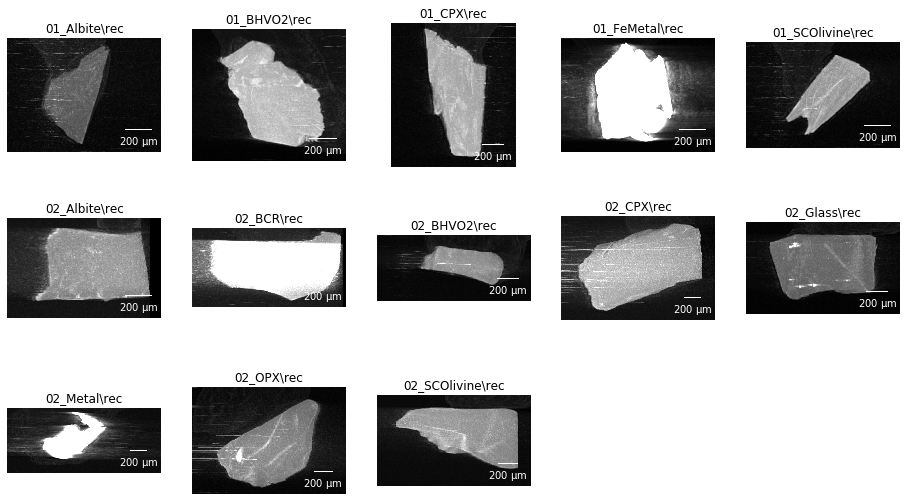

Coronal


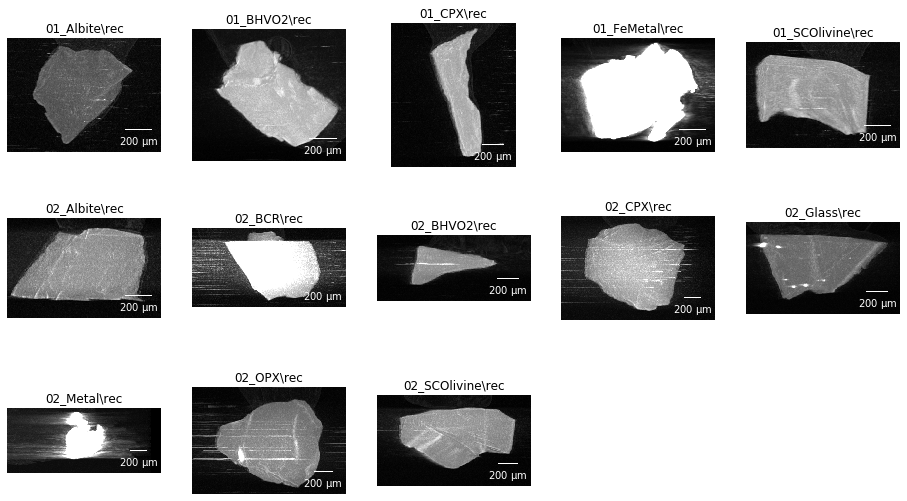

In [35]:
# Show MIPs together
for d, direction in enumerate(directions):
    print(direction)
    for c, row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        if row['Scan']:
            plt.title('%s' % os.path.join(row['Sample'], row['Scan']))
        else:
            plt.title('%s' % row['Sample'])
        plt.axis('off')
    plt.savefig(os.path.join(Root, 'MIPs.' + direction + '.png'),
                transparent=False,
                bbox_inches='tight')
    plt.show()